#  CNN from Scratch (NumPy) - MNIST Classifier
This notebook builds a dynamic Convolutional Neural Network entirely from scratch using NumPy, and trains it on the MNIST dataset.

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

class Layer:
    def forward(self, input): pass
    def backward(self, d_output, lr): pass


In [2]:
class Conv2D(Layer):
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size) / 9

    def iterate_regions(self, image):
        h, w = image.shape
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                yield i, j, image[i:i+self.filter_size, j:j+self.filter_size]

    def forward(self, input):
        self.last_input = input
        h, w = input.shape
        output = np.zeros((h - self.filter_size + 1, w - self.filter_size + 1, self.num_filters))
        for i, j, region in self.iterate_regions(input):
            output[i, j] = np.sum(region * self.filters, axis=(1, 2))
        return output

    def backward(self, d_output, lr):
        d_filters = np.zeros_like(self.filters)
        for i, j, region in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_filters[f] += d_output[i, j, f] * region
        self.filters -= lr * d_filters
        return np.zeros_like(self.last_input)


In [3]:
class ReLU(Layer):
    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)

    def backward(self, d_output, lr):
        return d_output * (self.last_input > 0)


In [4]:
class MaxPool2x2(Layer):
    def iterate_regions(self, image):
        h, w, f = image.shape
        for i in range(h // 2):
            for j in range(w // 2):
                yield i, j, image[i*2:i*2+2, j*2:j*2+2]

    def forward(self, input):
        self.last_input = input
        h, w, f = input.shape
        output = np.zeros((h // 2, w // 2, f))
        for i, j, region in self.iterate_regions(input):
            output[i, j] = np.max(region, axis=(0, 1))
        return output

    def backward(self, d_output, lr):
        return np.zeros_like(self.last_input)


In [5]:
class Flatten(Layer):
    def forward(self, input):
        self.orig_shape = input.shape
        return input.flatten()

    def backward(self, d_output, lr):
        return d_output.reshape(self.orig_shape)


In [6]:
class DenseSoftmax(Layer):
    def __init__(self, input_len, output_len):
        self.weights = np.random.randn(input_len, output_len) / input_len
        self.biases = np.zeros(output_len)

    def forward(self, input):
        self.last_input = input
        self.last_totals = np.dot(input, self.weights) + self.biases
        exp = np.exp(self.last_totals - np.max(self.last_totals))
        return exp / np.sum(exp)

    def backward(self, d_output, lr):
        for i, grad in enumerate(d_output):
            if grad == 0: continue
            t_exp = np.exp(self.last_totals - np.max(self.last_totals))
            S = np.sum(t_exp)
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
            d_L_d_t = grad * d_out_d_t
            d_t_d_w = self.last_input[:, np.newaxis]
            self.weights -= lr * d_t_d_w @ d_L_d_t[np.newaxis]
            self.biases -= lr * d_L_d_t
            return d_L_d_t @ self.weights.T


In [7]:
class CNN:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x, label=None):
        for layer in self.layers:
            x = layer.forward(x)
        self.output = x
        loss = -np.log(x[label]) if label is not None else None
        acc = 1 if np.argmax(x) == label else 0
        return x, loss, acc

    def train(self, x, label, lr=0.01):
        out, loss, acc = self.forward(x, label)
        grad = np.zeros(10)
        grad[label] = -1 / out[label]
        for layer in reversed(self.layers):
            grad = layer.backward(grad, lr)
        return loss, acc

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return np.argmax(x)


In [32]:
# Load and normalize MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:2000] / 255.0
y_train = y_train[:2000]
x_test = x_test[:200] / 255.0
y_test = y_test[:200]


In [29]:
# Building the model
model = CNN([
    Conv2D(8, 3),
    ReLU(),
    MaxPool2x2(),
    Flatten(),
    DenseSoftmax(13*13*8, 10)
])


In [35]:
# Train the model
for epoch in range(10):
    print(f"Epoch {epoch+1}")
    total_loss = 0
    total_acc = 0
    for i, (x, y) in enumerate(zip(x_train, y_train)):
        loss, acc = model.train(x, y, lr=0.005)
        total_loss += loss
        total_acc += acc
        if (i+1) % 100 == 0:
            print(f"[{i+1}] Loss: {total_loss/100:.4f}, Accuracy: {total_acc}%")
            total_loss, total_acc = 0, 0


Epoch 1
[100] Loss: 0.5459, Accuracy: 92%
[200] Loss: 0.5791, Accuracy: 87%
[300] Loss: 0.5109, Accuracy: 88%
[400] Loss: 0.4145, Accuracy: 93%
[500] Loss: 0.5447, Accuracy: 86%
[600] Loss: 0.6769, Accuracy: 85%
[700] Loss: 0.6941, Accuracy: 85%
[800] Loss: 0.5468, Accuracy: 88%
[900] Loss: 0.6156, Accuracy: 82%
[1000] Loss: 0.6082, Accuracy: 91%
[1100] Loss: 0.7654, Accuracy: 84%
[1200] Loss: 0.6388, Accuracy: 83%
[1300] Loss: 0.6670, Accuracy: 86%
[1400] Loss: 0.6299, Accuracy: 86%
[1500] Loss: 0.5247, Accuracy: 90%
[1600] Loss: 0.6005, Accuracy: 86%
[1700] Loss: 0.4995, Accuracy: 89%
[1800] Loss: 0.4189, Accuracy: 95%
[1900] Loss: 0.4824, Accuracy: 88%
[2000] Loss: 0.5343, Accuracy: 85%
Epoch 2
[100] Loss: 0.5024, Accuracy: 93%
[200] Loss: 0.5360, Accuracy: 87%
[300] Loss: 0.4783, Accuracy: 88%
[400] Loss: 0.3709, Accuracy: 92%
[500] Loss: 0.5027, Accuracy: 87%
[600] Loss: 0.6268, Accuracy: 85%
[700] Loss: 0.6472, Accuracy: 86%
[800] Loss: 0.5027, Accuracy: 90%
[900] Loss: 0.5842, A

In [36]:
# Evaluate on test set
correct = 0
for x, y in zip(x_test, y_test):
    pred = model.predict(x)
    if pred == y:
        correct += 1
print(f"Test Accuracy: {correct / len(x_test) * 100:.2f}%")


Test Accuracy: 90.00%


Shape after Input: (28, 28)


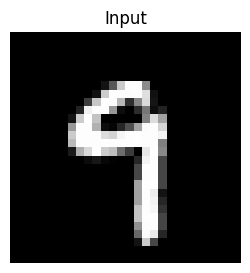

Shape after Conv2D (Layer 0): (26, 26, 8)


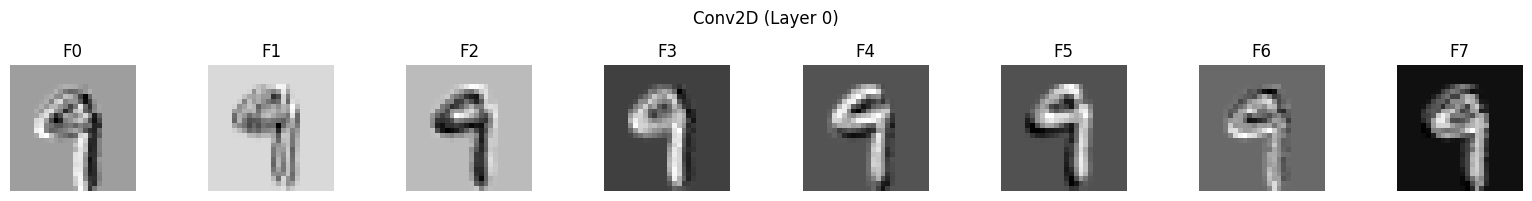

Shape after ReLU (Layer 1): (26, 26, 8)


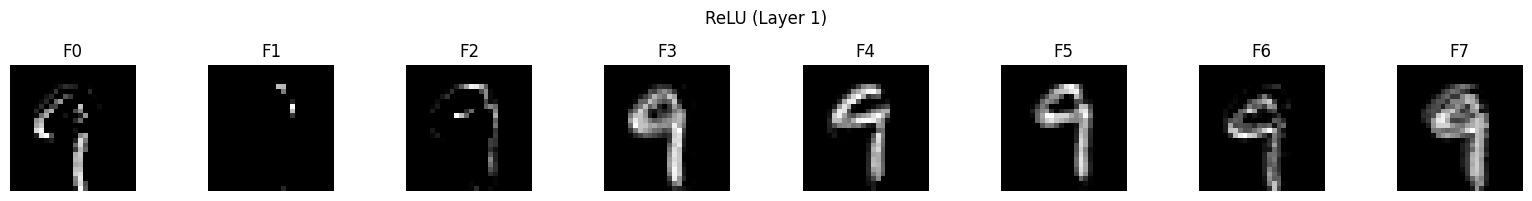

Shape after MaxPool2x2 (Layer 2): (13, 13, 8)


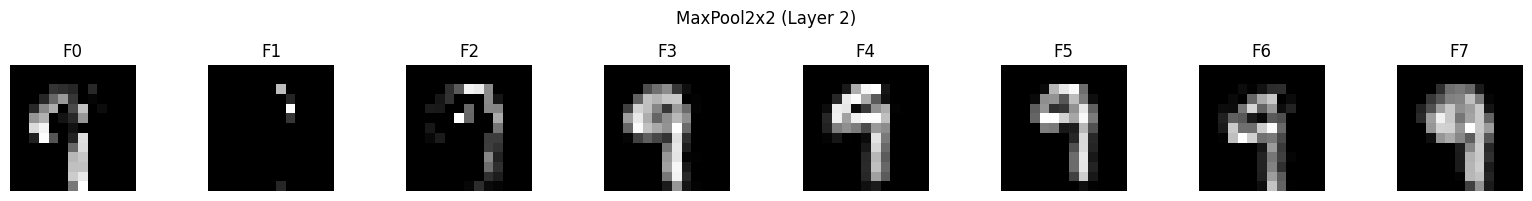

Shape after Flatten (Layer 3): (1352,)


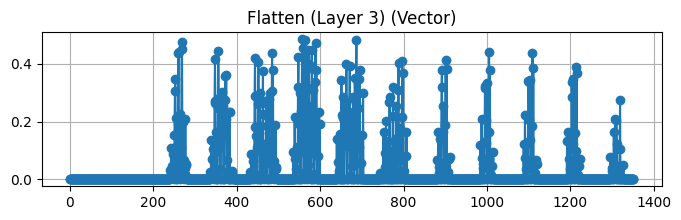

Shape after DenseSoftmax (Layer 4): (10,)


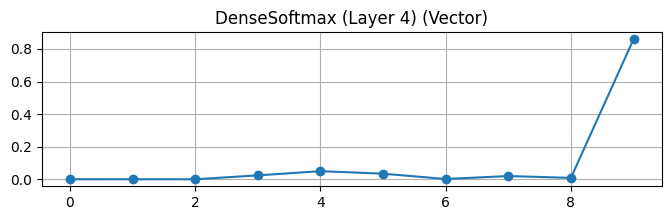

In [39]:
# Visualize the output of ALL layers from input to final softmax
import matplotlib.pyplot as plt
import numpy as np

def visualize_all_layers(model, image):
    x = image
    titles = ["Input"]
    activations = [x]

    for i, layer in enumerate(model.layers):
        x = layer.forward(x)
        activations.append(x)
        titles.append(f"{layer.__class__.__name__} (Layer {i})")

    for idx, (act, title) in enumerate(zip(activations, titles)):
        print(f"Shape after {title}: {act.shape}")
        if act.ndim == 2:
            plt.figure(figsize=(3, 3))
            plt.imshow(act, cmap='gray')
            plt.title(title)
            plt.axis('off')
            plt.show()

        elif act.ndim == 3:
            num_filters = act.shape[-1]
            cols = min(num_filters, 8)
            rows = int(np.ceil(num_filters / cols))
            fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
            fig.suptitle(title)
            axs = np.array(axs).reshape(rows, cols)

            for i in range(rows * cols):
                ax = axs[i // cols, i % cols]
                if i < num_filters:
                    ax.imshow(act[:, :, i], cmap='gray')
                    ax.set_title(f'F{i}')
                ax.axis('off')
            plt.tight_layout()
            plt.show()

        elif act.ndim == 1:
            plt.figure(figsize=(8, 2))
            plt.plot(act, marker='o')
            plt.title(f"{title} (Vector)")
            plt.grid(True)
            plt.show()

visualize_all_layers(model, x_test[108])
